In [1]:
# Standard data science libraries
import pandas as pd
import numpy as np
import scipy as scp
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

__Question 2__ :

In [3]:
# Some utils functions for generalized use
def rand_weighted(p):
    M = p.shape[0]
    return np.random.choice(range(0,M),p=p)
def normalize(u):
    return u/np.sum(u)
def EWA_update(p,l,eta):
    return normalize(np.multiply(p,np.exp(-eta*l)))

__Questions 3.(a) to 3.(e)__

In [4]:
#General Use Agent class
class Agent(object):
    def __init__(self,LossMatrix=None,M = 3, bandit = False):
        self.bandit = bandit
        self.t = 0 #time step
        self.M = M #number of actions
        if not self.bandit:
            self.L = LossMatrix # Loss matrix of the game
        if not (LossMatrix is None) :
            self.M = self.L.shape[0]
        self.p = normalize(1.0+np.zeros((self.M,))) # the agent starts by uniform weights on actions
        
    def update(self,action,adv_action,loss=None):
        pass
    def act(self) :
        pass

class Fixed_agent(Agent): # Dumb agent with fixed strategy
    def __init__(self,LossMatrix,p) :
        super().__init__(LossMatrix,bandit=False)
        self.p = p # fixed vector of actions weights
    def update(self,action,adv_action,loss):
        self.t+=1
    def act(self):
        return self.p.copy()

class EWA_agent(Agent): # Agent playing with exponential weighted average strategy
    def __init__(self,LossMatrix,eta) :
        super().__init__(LossMatrix,bandit=False)
        self.eta = eta 
    def update(self,action,adv_action,loss):
        self.t+=1
        l = self.L[:,adv_action] #EWA needs loss of all actions when adversary plays adv_action
        self.p = EWA_update(self.p.copy(),l,self.eta)
    def act(self):
        return self.p.copy()

In [10]:
# Simulate playing a game
def playGame(L,T,player,adversary, zero_sum=True, advL=None):
    # L, advL are respectively the loss matrix of the player and adversary
    # T  is time horizon
    #both players have a randomized strategy with changing probability vectors p and q
    M = L.shape[0] # number of actions of player
    N = L.shape[1] # number of actions of adversary
    p = player.act()
    q = adversary.act()
    history = {'p':[], 'q':[],'loss': [], 'advloss':[] ,'regret':[], 'fixedActionloss' : np.zeros(M)}
    cumLoss = 0
    cumAdvLoss = 0
    cumRegret = 0
    Times = range(1,T+1)
    for t in Times:
        i = rand_weighted(p)
        j = rand_weighted(q)
        pLoss = L[i,j]
        if zero_sum :
            qLoss = -pLoss
        else:
            qLoss = advL[j,i]
        cumLoss+= pLoss
        cumAdvLoss += qLoss
        # This line is only for Rock-Paper-Scissors game with fixed adversary playing [0.5,0.25,0.25]
        # we compare with the best fixed action which we already know to be playing Paper always
        cumRegret += L[i,j] - L[1,j] 
        # Record all info about the move
        history['p'].append(p)
        history['q'].append(q)
        history['loss'].append(cumLoss)
        history['advloss'].append(cumAdvLoss)
        history['regret'].append(cumRegret)
        history['fixedActionloss'] += L[:,j] # keep track of losses had we played other actions to compute regret later
        #Update internal parameters of the agents
        player.update(i,j,pLoss)
        adversary.update(j,i,qLoss)
        # Choose action weights for next move
        p = player.act()
        q = adversary.act()
    
    bestLoss = np.min(history['fixedActionloss']) # best possible loss with a fixed agent
    Regret = history['loss'][-1] - bestLoss
    return Regret,history

def avgLoss(history): #Computing so-far-average loss for every step of the game
    avgloss = history['loss']
    for t in range(len(avgloss)):
        avgloss[t] = avgloss[t]/(t+1)
    return avgloss
def avgAdvLoss(history):
    avgloss = history['advloss']
    for t in range(len(avgloss)):
        avgloss[t] = avgloss[t]/(t+1)
    return avgloss

In [14]:
# Function to plot Average loss, cumulative regret, and evolution of actions weights
def plotGame(history) : 
    P = np.array(history['p'])
    avgloss = avgLoss(history)
    #Plots, lots of plots   
    Times = range(1,T+1) 
    plt.figure(figsize=(20,15))
    plt.subplot(3,2,1)
    plt.plot(Times,avgloss)
    plt.xlabel("time")
    plt.title("Average Loss")
    plt.subplot(3,2,2)
    plt.plot(Times,history['regret'])
    plt.xlabel("time")
    plt.title("Cumulative Regret")
    plt.subplot(3,2,3)
    plt.plot(Times,P[:,0])
    plt.xlabel("time")
    plt.title("probability of playing Rock")
    plt.subplot(3,2,4)
    plt.plot(Times,P[:,1])
    plt.xlabel("time")
    plt.title("probability of playing Paper")
    plt.subplot(3,2,5)
    plt.plot(Times,P[:,2])
    plt.xlabel("time")
    plt.title("probability of playing Scissors")
    plt.show()

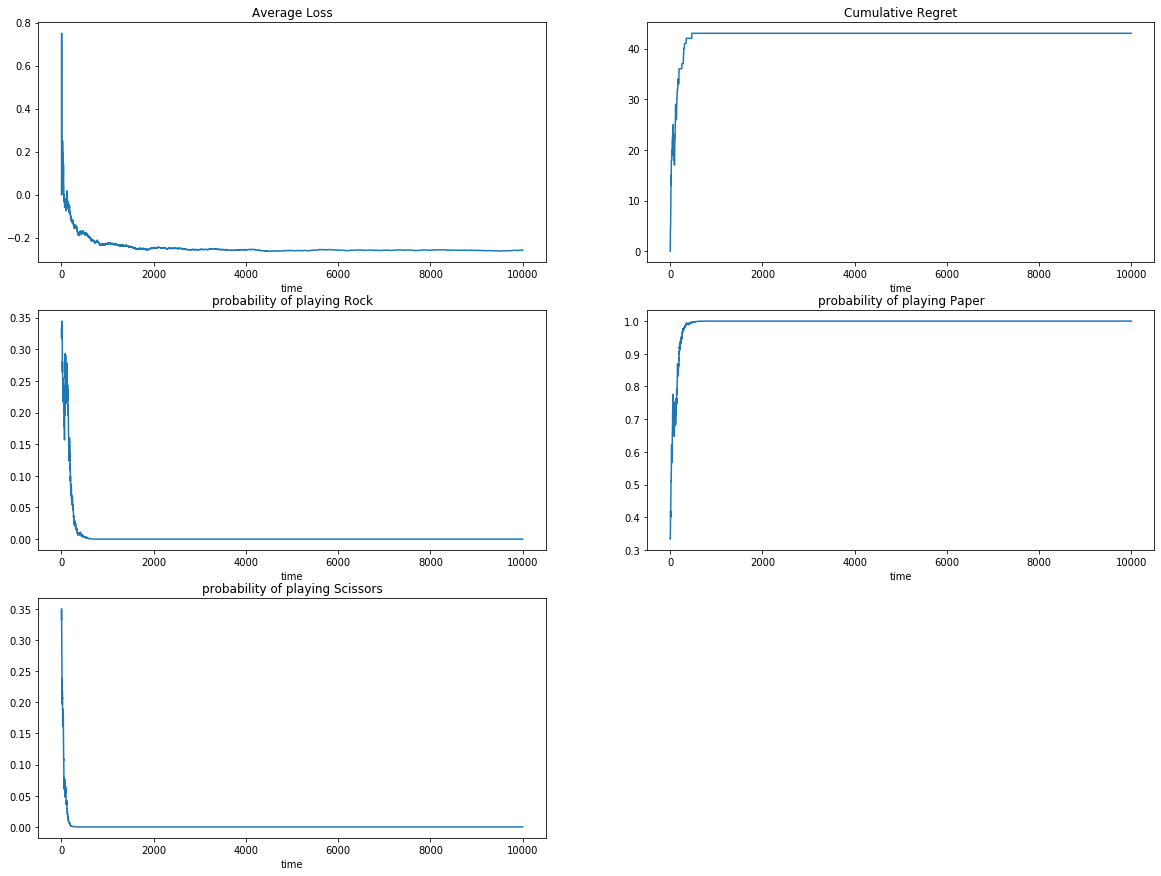

In [15]:
# HYPERPARAMETER SETTING
# We index actions as follows : Rock = 1st, Paper = 2nd, Scissors = 3rd
L = np.array([[0,1,-1],[-1,0,1],[1,-1,0]])
T = 10**4
eta = 0.05
q = np.array([0.5,0.25,0.25])
EWA = EWA_agent(L,eta)
FIXED = Fixed_agent(-L.T, p = q) 
_, history =playGame(L,T,player=EWA,adversary=FIXED)
plotGame(history)

__Question 3.(f)__ : Variance of the loss collected by playing EWA algorithm

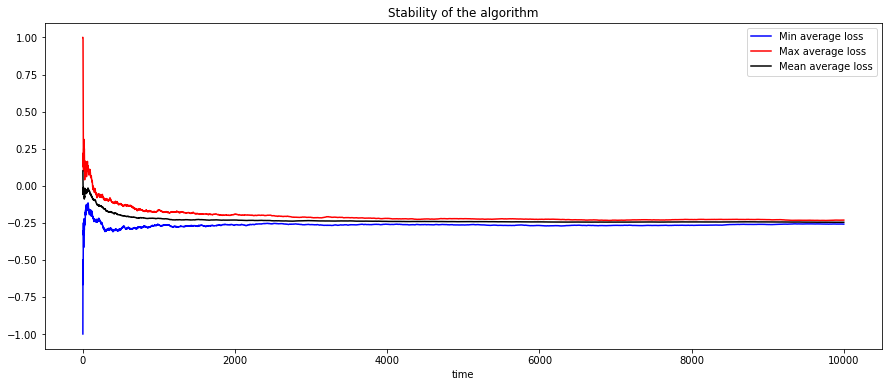

In [18]:
AvgLosses=[]
for n in range(10):
    EWA = EWA_agent(L,eta)
    FIXED = Fixed_agent(L.T, p = q) 
    _, history =playGame(L,T,player=EWA,adversary=FIXED)
    AvgLosses.append(avgLoss(history))
AvgLosses = np.array(AvgLosses)
Times = range(1,T+1)
plt.figure(figsize=(15,6))
plt.plot(Times,np.min(AvgLosses,axis=0),'b',label='Min average loss')
plt.plot(Times,np.max(AvgLosses,axis=0),'r',label='Max average loss')
plt.plot(Times,np.mean(AvgLosses,axis=0),'k',label='Mean average loss')
plt.xlabel("time")
plt.title("Stability of the algorithm")
plt.legend()
plt.show()

__Question 3.(f)__ : Dependance of Total regret on eta

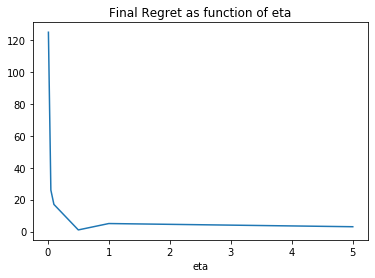

In [19]:
Etas = [0.01, 0.05, 0.1, 0.5, 1,5]
finalR = [] # Final Regret
for eta in Etas:
    EWA = EWA_agent(L,eta)
    FIXED = Fixed_agent(-L.T, p = q) 
    Regret, history =playGame(L,T,player=EWA,adversary=FIXED)
    finalR.append(Regret)
plt.plot(Etas,finalR)
plt.xlabel('eta')
plt.title('Final Regret as function of eta')
plt.show()

__Question 4__ : Two EWA agents playing against each other

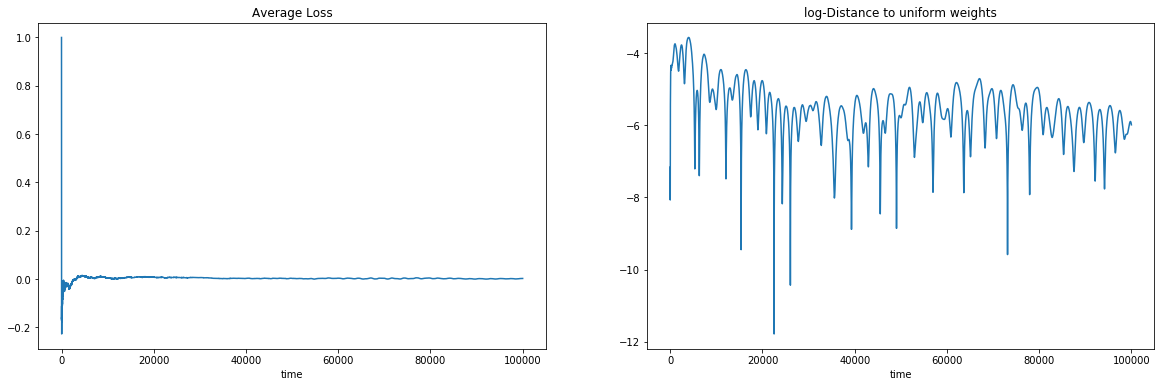

In [10]:
import warnings
warnings.simplefilter("ignore")
T = 10**5
player_eta = np.sqrt(np.log(3)/T)
adv_eta = np.sqrt(np.log(3)/T)
EWA1 = EWA_agent(L,player_eta)
EWA2 = EWA_agent(-L.T, adv_eta) 
_,history = playGame(L,T,player=EWA1,adversary=EWA2)
avgloss = avgLoss(history)
P = np.array(history['p'])
avgP = np.cumsum(P,axis=0)
for t in range(T):
    avgP[t] = avgP[t]/(1+t)
#Plot Average loss to see if it converges to the Value of the game (zero)
Times = range(1,T+1)
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(Times,avgloss)
plt.xlabel("time")
plt.title("Average Loss")
#Plot the log distance of the average action weights to the nash equilibrium (strategy with p = [1/3,1/3,1/3])
plt.subplot(1,2,2)
plt.plot(Times,np.log(np.linalg.norm(avgP-np.array([1/3,1/3,1/3]),axis=1)))
plt.xlabel("time")
plt.title("log-Distance to uniform weights")
plt.show()

__Question 5__ : EXP3 strategy

In [7]:
def estimated_loss(p,i,loss,M=3):
    l = np.zeros(M)
    l[i] = loss/p[i]
    return l
def EXP3_update(p,i,loss,eta):
    M = p.shape[0]
    l = estimated_loss(p,i,loss,M)
    return EWA_update(p,l,eta)

class EXP3_agent(Agent): # Agent playing with EXP3 strategy
    def __init__(self,LossMatrix,eta) :
        super().__init__(LossMatrix=None,bandit=True)
        self.eta = eta 
    def update(self,action,adv_action,loss):
        self.t+=1
        #EXP3 is designed for a Bandit setting, so only needs incured loss
        self.p = EXP3_update(self.p.copy(),action,loss,self.eta)
    def act(self):
        return self.p.copy()

__Question 6__ : EXP3 against Fixed-strategy-adversary

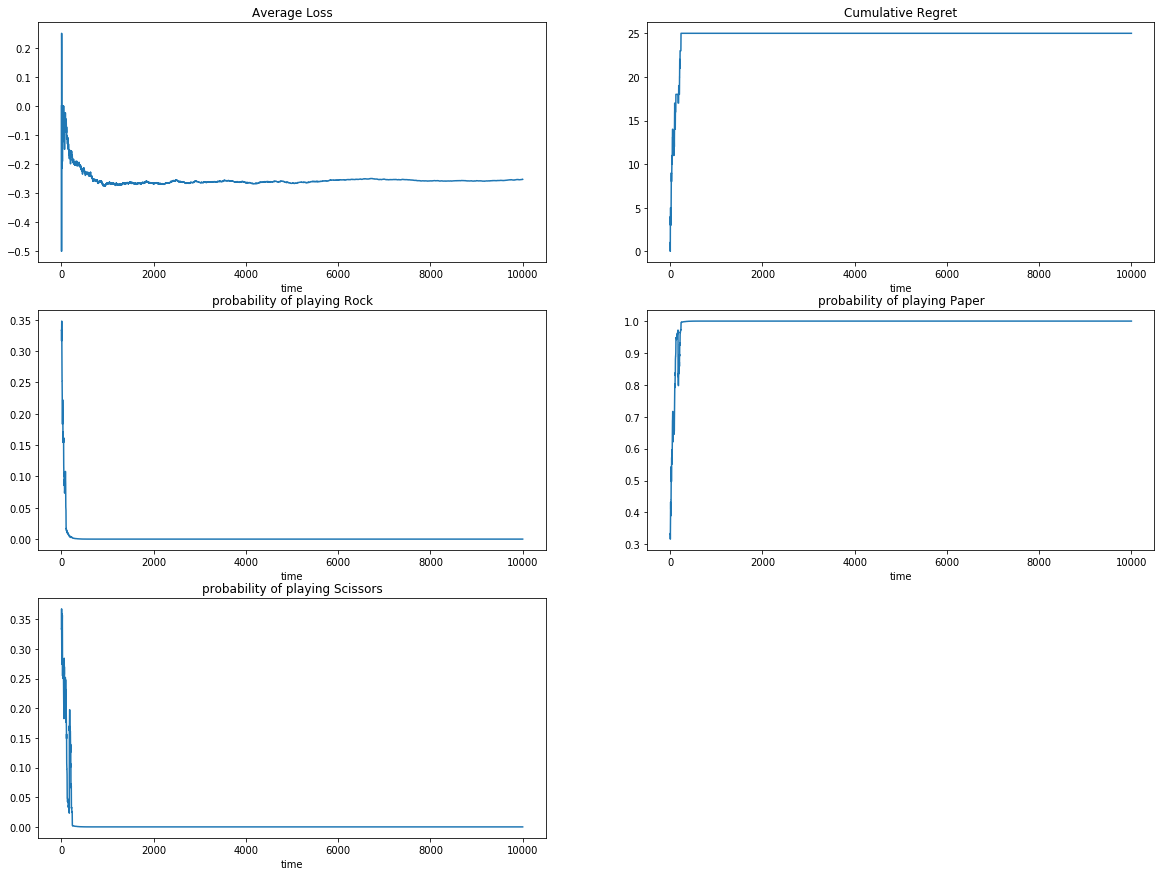

In [20]:
T = 10**4
eta = 0.05
q = np.array([0.5,0.25,0.25])
EXP3 = EXP3_agent(LossMatrix=None,eta=eta)
FIXED = Fixed_agent(LossMatrix=None, p = q) 
_, history =playGame(L,T,player=EXP3,adversary=FIXED)
plotGame(history)

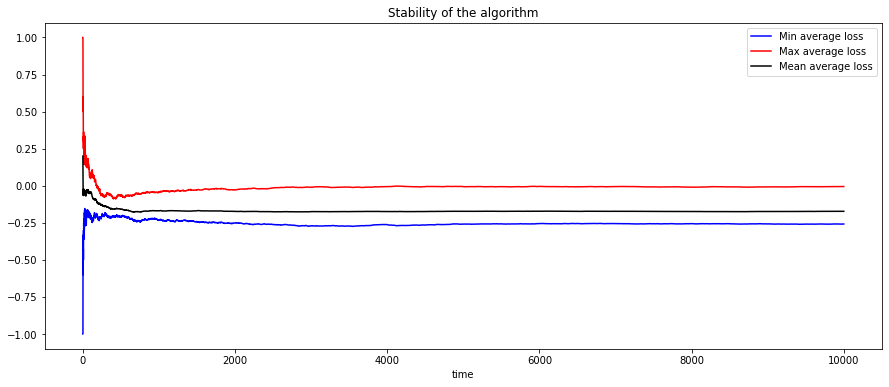

In [21]:
AvgLosses=[]
for n in range(10):
    q = np.array([0.5,0.25,0.25])
    EXP3 = EXP3_agent(LossMatrix=None,eta=eta)
    FIXED = Fixed_agent(LossMatrix=None, p = q) 
    _, history =playGame(L,T,player=EXP3,adversary=FIXED)
    AvgLosses.append(avgLoss(history))
AvgLosses = np.array(AvgLosses)
Times = range(1,T+1)
plt.figure(figsize=(15,6))
plt.plot(Times,np.min(AvgLosses,axis=0),'b',label='Min average loss')
plt.plot(Times,np.max(AvgLosses,axis=0),'r',label='Max average loss')
plt.plot(Times,np.mean(AvgLosses,axis=0),'k',label='Mean average loss')
plt.xlabel("time")
plt.title("Stability of the algorithm")
plt.legend()
plt.show()

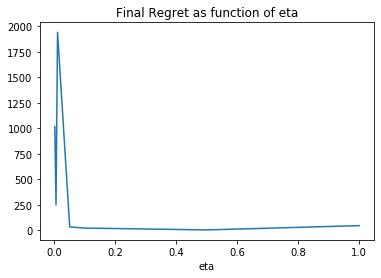

In [22]:
Etas = [1e-3,5e-3,0.01, 0.05, 0.1, 0.5, 1]
finalR = [] # Final Regret
for eta in Etas:
    q = np.array([0.5,0.25,0.25])
    EXP3 = EXP3_agent(LossMatrix=None,eta=eta)
    FIXED = Fixed_agent(LossMatrix=None, p = q) 
    _, history =playGame(L,T,player=EXP3,adversary=FIXED)
    finalR.append(history['regret'][-1])
plt.plot(Etas,finalR)
plt.xlabel('eta')
plt.title('Final Regret as function of eta')
plt.show()

__Question 7__: Two EXP3 bandits playing against each other

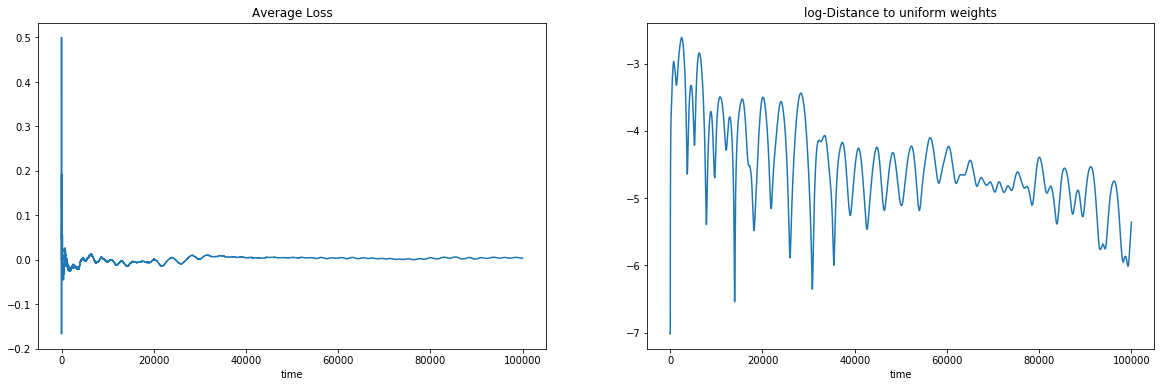

In [24]:
import warnings
warnings.simplefilter("ignore")
T = 10**5
player_eta = np.sqrt(np.log(3)/T)
adv_eta = np.sqrt(np.log(3)/T)
EXP3_1 = EXP3_agent(None,player_eta)
EXP3_2 = EXP3_agent(None, adv_eta) 
_,history = playGame(L,T,player=EXP3_1,adversary=EXP3_2)
avgloss = avgLoss(history)
P = np.array(history['p'])
avgP = np.cumsum(P,axis=0)
for t in range(T):
    avgP[t] = avgP[t]/(1+t)
#Plot Average loss to see if it converges to the Value of the game (zero)
Times = range(1,T+1)
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(Times,avgloss)
plt.xlabel("time")
plt.title("Average Loss")
#Plot the log distance of the average action weights to the nash equilibrium (strategy with p = [1/3,1/3,1/3])
plt.subplot(1,2,2)
plt.plot(Times,np.log(np.linalg.norm(avgP-np.array([1/3,1/3,1/3]),axis=1)))
plt.xlabel("time")
plt.title("log-Distance to uniform weights")
plt.show()

__Question 8__ : UCB agent vs EXP3 agent. first we code a UCB agaent.

In [12]:
class UCB_agent(Agent):
    def __init__(self,LossMatrix) :
        super().__init__(LossMatrix=None,bandit=True)
         # list of number of times every action was played
        self.N_plays = np.zeros(self.M) #initialized at one to avoid division by zero in upper bound construction
        self.avgLoss = np.zeros(self.M)  # Average loss for every arm/action
    def update(self,action,adv_action,loss):
        self.t+=1
        self.avgLoss[action] = (self.N_plays[action]*self.avgLoss[action]+loss)/(1+self.N_plays[action])
        self.N_plays[action]+=1
    def act(self):
        if self.t < self.M :
            self.p = np.zeros(self.M)
            self.p[self.t] = 1.0
        else :
            # since we're working with losses, being optimistic means taking a lower bound on losses
            bounds = self.avgLoss- np.sqrt(2*np.log(self.t)*np.reciprocal(self.N_plays))
            a = np.argmin(bounds)
            self.p = np.zeros(self.M)
            self.p[a] = 1.0
        return self.p.copy()

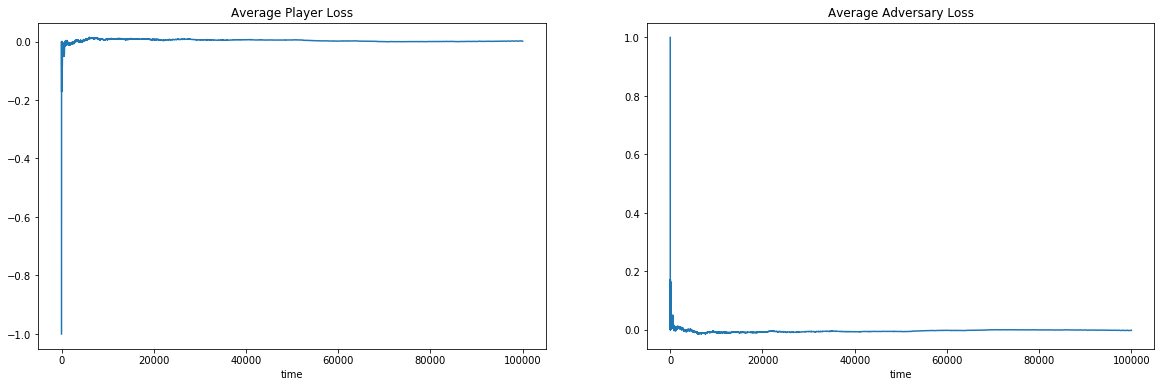

In [29]:
T = 10**5
player_eta = np.sqrt(np.log(3)/T)
EXP3 = EXP3_agent(None,player_eta)
UCB = UCB_agent(None) 
_,history = playGame(L,T,player=EXP3,adversary=UCB)
avgloss = avgLoss(history)
Adv_avgloss = avgAdvLoss(history)
#Plot Average losses of player and adversary to see who wins
Times = range(1,T+1)
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(Times,avgloss)
plt.xlabel("time")
plt.title("Average Player Loss")
plt.subplot(1,2,2)
plt.plot(Times,Adv_avgloss)
plt.xlabel("time")
plt.title("Average Adversary Loss")
plt.show()

__UCB and EXP3 seem to have the same performance, none of the algorithms beats the other__

__Question 10__ : Non-zero-sum game : Prisoner's dilemma. We assume a full information setup.

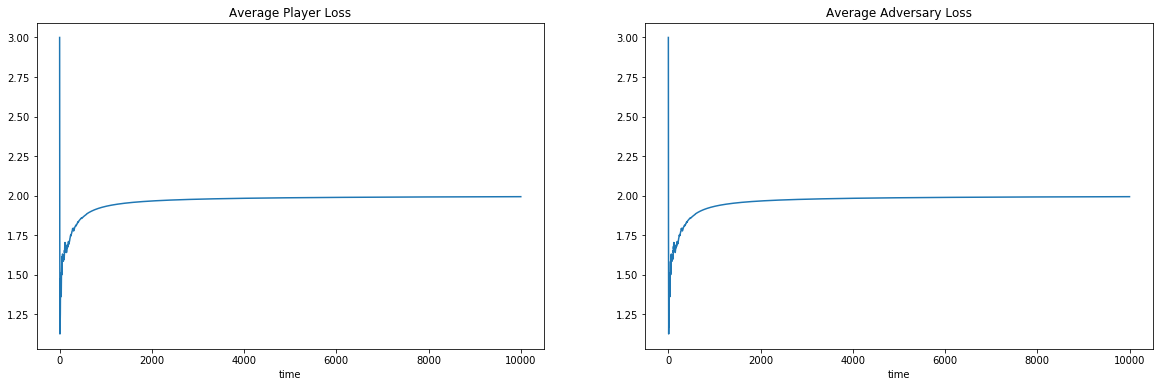

In [28]:
L_player = np.array([[1,3],[0,2]])
# The code for agents and simulation of the game assumes lines of L_adversary are actions of adversary 
# and columns of L_adversary are actions of player, so instead of L_adv = L_player.T we write L_adv = L_player 
L_adv = L_player 
T = 10**4
player_eta = np.sqrt(np.log(3)/T)
adv_eta = np.sqrt(np.log(3)/T)
EWA1 = EWA_agent(L_player,player_eta)
EWA2 = EWA_agent(L_adv, adv_eta) 
_,history = playGame(L=L_player,T=T,player=EWA1,adversary=EWA2,zero_sum=False, advL=L_adv)
avgloss = avgLoss(history)
Adv_avgloss = avgAdvLoss(history)
P = np.array(history['p'])
avgP = np.cumsum(P,axis=0)
for t in range(T):
    avgP[t] = avgP[t]/(1+t)
#Plot Average losses of player and adversary to see who wins
Times = range(1,T+1)
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(Times,avgloss)
plt.xlabel("time")
plt.title("Average Player Loss")
plt.subplot(1,2,2)
plt.plot(Times,Adv_avgloss)
plt.xlabel("time")
plt.title("Average Adversary Loss")
plt.show()